In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random
from sklearn.preprocessing import normalize

from collections import Counter
from scipy.stats import mode
import pickle


# final ranking path ordr

In [14]:
# Load features and paths
with open("ds.pkl", "rb") as f:
    data = pickle.load(f)

# Separate features and paths
features = [item[0] for item in data]
ds_paths = [item[1] for item in data]

# Convert features back to a tensor
ds_feats = torch.tensor(features)

In [15]:
# Load features and paths
with open("sd.pkl", "rb") as f:
    data = pickle.load(f)

# Separate features and paths
features = [item[0] for item in data]
sd_paths = [item[1] for item in data]

# Convert features back to a tensor
sd_feats = torch.tensor(features)

In [17]:
# File paths
centroid_path = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\final_ranking\sd103_centroid.npy"


Sorted distances and paths:
Cosine Distance: 0.0855, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_E11-T01.tiff, Group: Single Dose
Cosine Distance: 0.1060, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_F10-T01.tiff, Group: Single Dose
Cosine Distance: 0.1592, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_B09-T01.tiff, Group: Single Dose
Cosine Distance: 0.1618, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.04_Day10_F11-T01.tiff, Group: Single Dose
Cosine Distance: 0.1780, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_G09-T01.tiff, Group: Single Dose
Cosine Distance: 0.1814, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inferen

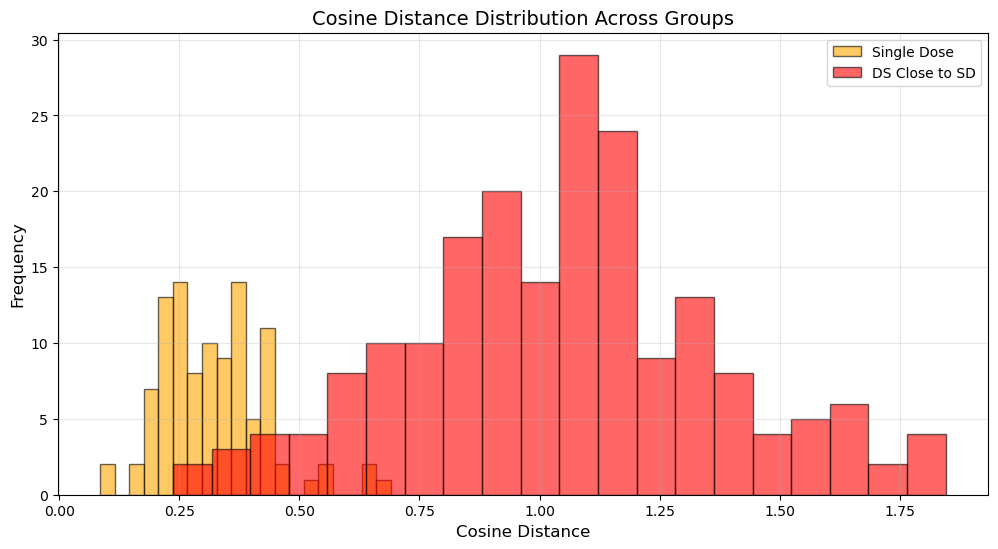

In [21]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def cal_and_plot(centroid_path, sd_feats, sd_paths, ds_feats, ds_paths, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances. Also prints features and their corresponding paths in ascending order of cosine distances.

    Parameters:
        centroid_path (str): Path to the centroid .npy file.
        sd_feats (torch.Tensor): Features for single-dose group.
        sd_paths (list): Corresponding paths for single-dose features.
        ds_feats (torch.Tensor): Features for ds_closeto_sd group.
        ds_paths (list): Corresponding paths for ds_closeto_sd features.
        bins (int): Number of bins for the histogram.
    """
    # Load the centroid
    cosine_centroid = np.load(centroid_path).reshape(1, -1)  # Shape: [1, 512]

    # Convert features to numpy arrays
    sd_np_norm = sd_feats.numpy()
    ds_np_norm = ds_feats.numpy()

    # Compute cosine distances
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()
    ds_cosine_distances = 1 - cosine_similarity(ds_np_norm, cosine_centroid).flatten()

    # Combine distances with paths, including group labels
    combined_distances = (
        [(dist, path, "Single Dose") for dist, path in zip(sd_cosine_distances, sd_paths)] +
        [(dist, path, "DS Close to SD") for dist, path in zip(ds_cosine_distances, ds_paths)]
    )

    # Sort combined distances by ascending order
    combined_distances_sorted = sorted(combined_distances, key=lambda x: x[0])

    # Print sorted distances and paths
    print("\nSorted distances and paths:")
    for distance, path, group in combined_distances_sorted:
        print(f"Cosine Distance: {distance:.4f}, Path: {path}, Group: {group}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")
    plt.hist(ds_cosine_distances, bins=bins, alpha=0.6, label="DS Close to SD", color="red", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "combined_distances_sorted": combined_distances_sorted,
    }

# Example usage
distances = cal_and_plot(centroid_path, sd_feats, sd_paths, ds_feats, ds_paths, bins=20)



Sorted distances and paths:
Cosine Distance: 0.0855, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_E11-T01.tiff, Group: Single Dose
Cosine Distance: 0.1060, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_F10-T01.tiff, Group: Single Dose
Cosine Distance: 0.1592, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_B09-T01.tiff, Group: Single Dose
Cosine Distance: 0.1618, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.04_Day10_F11-T01.tiff, Group: Single Dose
Cosine Distance: 0.1780, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference_ds_ohne_cond10\sd\sd_RBT_01.09_Day10_G09-T01.tiff, Group: Single Dose
Cosine Distance: 0.1814, Path: C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inferen

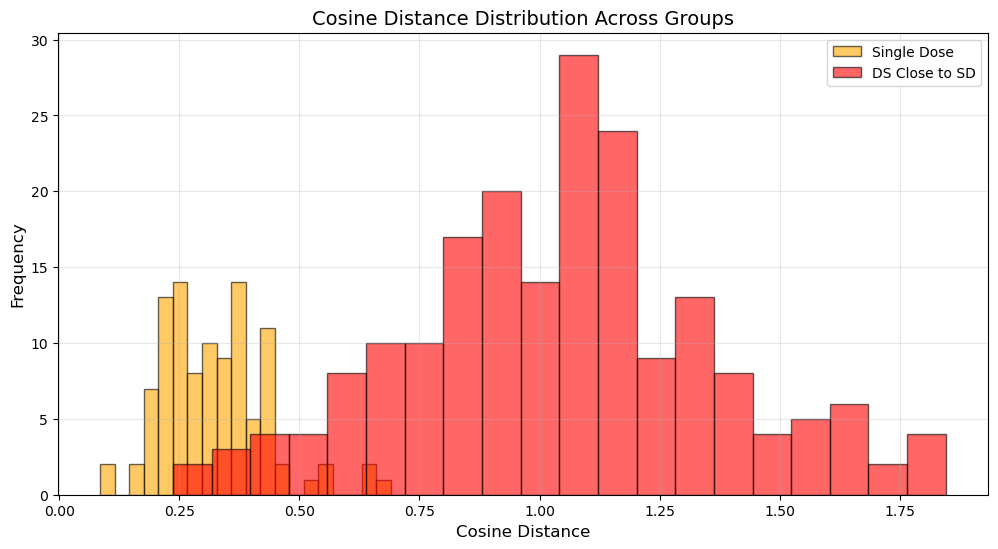

In [23]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import shutil

def cal_and_plot(centroid_path, sd_feats, sd_paths, ds_feats, ds_paths, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances. Also prints features and their corresponding paths in ascending order of cosine distances.

    Additionally, copies images in ascending order of cosine distances to a specified folder,
    renaming them to include the distance in the file name.

    Parameters:
        centroid_path (str): Path to the centroid .npy file.
        sd_feats (torch.Tensor): Features for single-dose group.
        sd_paths (list): Corresponding paths for single-dose features.
        ds_feats (torch.Tensor): Features for ds_closeto_sd group.
        ds_paths (list): Corresponding paths for ds_closeto_sd features.
        bins (int): Number of bins for the histogram.
    """
    # Load the centroid
    cosine_centroid = np.load(centroid_path).reshape(1, -1)  # Shape: [1, 512]

    # Convert features to numpy arrays
    sd_np_norm = sd_feats.numpy()
    ds_np_norm = ds_feats.numpy()

    # Compute cosine distances
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()
    ds_cosine_distances = 1 - cosine_similarity(ds_np_norm, cosine_centroid).flatten()

    # Combine distances with paths, including group labels
    combined_distances = (
        [(dist, path, "Single Dose") for dist, path in zip(sd_cosine_distances, sd_paths)] +
        [(dist, path, "DS Close to SD") for dist, path in zip(ds_cosine_distances, ds_paths)]
    )

    # Sort combined distances by ascending order
    combined_distances_sorted = sorted(combined_distances, key=lambda x: x[0])

    # Print sorted distances and paths
    print("\nSorted distances and paths:")
    for distance, path, group in combined_distances_sorted:
        print(f"Cosine Distance: {distance:.4f}, Path: {path}, Group: {group}")

    # Define the target directory for copying images
    target_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\sort_kmeans_cosine"
    os.makedirs(target_dir, exist_ok=True)

    # Copy and rename images
    for distance, path, _ in combined_distances_sorted:
        # Extract the original file name
        original_name = os.path.basename(path)

        # Create the new file name with distance prepended
        new_name = f"{distance:.4f}_{original_name}"

        # Define the destination path
        dest_path = os.path.join(target_dir, new_name)

        # Copy the file to the destination with the new name
        shutil.copy(path, dest_path)

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")
    plt.hist(ds_cosine_distances, bins=bins, alpha=0.6, label="DS Close to SD", color="red", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "combined_distances_sorted": combined_distances_sorted,
    }

# Example usage
distances = cal_and_plot(centroid_path, sd_feats, sd_paths, ds_feats, ds_paths, bins=20)


import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

def cal_and_plot(centroid_path, sd_feats, sd_paths, ds_feats, ds_paths, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances. Also prints ds_closeto_sd features and their corresponding paths in ascending order of cosine distances.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .npy file.
        ds_closeto_sd_features (torch.Tensor): Features for ds_closeto_sd.
        ds_closeto_sd_paths (list): Corresponding paths for ds_closeto_sd features.
        bins (int): Number of bins for the histogram.
    """

    cosine_centroid = np.load(centroid_path)


    sd_np_norm = sd_feats.numpy()
    ds_norm = ds_feats.numpy()

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

   
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()
    ds_cosine_distances = 1 - cosine_similarity(ds_norm, cosine_centroid).flatten()

    # Combine distances with paths
    sd_with_paths = list(zip(sd_cosine_distances, sd_paths))
    sd_with_paths_sorted = sorted(sd_with_paths, key=lambda x: x[0])  # Sort by cosine distance


    # Combine distances with paths
    ds_with_paths = list(zip(ds_cosine_distances, ds_paths))
    ds_with_paths_sorted = sorted(ds_with_paths, key=lambda x: x[0])  # Sort by cosine distance



    # Print sorted distances and paths
    print("\nSorted sd distances and paths:")
    for distance, path in sd_with_paths_sorted:
        print(f"Cosine Distance: {distance:.4f}, Path: {path}")


    # Print sorted distances and paths
    print("\nSorted ds distances and paths:")
    for distance, path in ds_with_paths_sorted:
        print(f"Cosine Distance: {distance:.4f}, Path: {path}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")
    plt.hist(ds_cosine_distances, bins=bins, alpha=0.6, label="ds close to sd", color="red", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "sd_cosine_distances": sd_cosine_distances,
        "ds_closeto_sd_cosine_distances": ds_cosine_distances,
    }





# Call the function
distances = cal_and_plot(
    centroid_path,
    sd_feats,
    sd_paths,
    ds_feats,
    ds_paths,
    bins=20
)


import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pickle

def cal_and_plot(exp_path, control_path, sd_path, centroid_path, ds_closeto_sd_features, ds_closeto_sd_paths, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    then plot histograms of these distances. Also prints ds_closeto_sd features and their corresponding paths in ascending order of cosine distances.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .npy file.
        ds_closeto_sd_features (torch.Tensor): Features for ds_closeto_sd.
        ds_closeto_sd_paths (list): Corresponding paths for ds_closeto_sd features.
        bins (int): Number of bins for the histogram.
    """

    cosine_centroid = np.load(centroid_path)


    sd_np_norm = sd.numpy()
    ds_closeto_sd_norm = ds_closeto_sd_features.numpy()

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

   
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()
    ds_closeto_sd_cosine_distances = 1 - cosine_similarity(ds_closeto_sd_norm, cosine_centroid).flatten()

    # Combine distances with paths
    ds_closeto_sd_with_paths = list(zip(ds_closeto_sd_cosine_distances, ds_closeto_sd_paths))
    ds_closeto_sd_with_paths_sorted = sorted(ds_closeto_sd_with_paths, key=lambda x: x[0])  # Sort by cosine distance

    # Print sorted distances and paths
    print("\nSorted ds_closeto_sd distances and paths:")
    for distance, path in ds_closeto_sd_with_paths_sorted:
        print(f"Cosine Distance: {distance:.4f}, Path: {path}")

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")
    plt.hist(ds_closeto_sd_cosine_distances, bins=bins, alpha=0.6, label="ds close to sd", color="red", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Return calculated distances for further use
    return {
        "sd_cosine_distances": sd_cosine_distances,
        "ds_closeto_sd_cosine_distances": ds_closeto_sd_cosine_distances,
    }





# Call the function
distances = cal_and_plot(
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    ds_features,
    ds_paths,
    bins=20
)


In [2]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import shutil

In [5]:
def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances, calculated metrics, and accuracy.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Task 1: Calculate and print mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    print("Mean Cosine Distances:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Task 2: Find the group with the middle mean
    means = [mean_control, mean_exp, mean_sd]
    groups = ["Control", "Exploded", "Single Dose"]
    middle_index = np.argsort(means)[1]
    middle_group = groups[middle_index]
    print(f"Group with middle mean: {middle_group}")

    # Task 3: Determine middle cluster bounds
    middle_distances = [control_cosine_distances, exp_cosine_distances, sd_cosine_distances][middle_index]
    middle_cluster_min = np.min(middle_distances)
    middle_cluster_max = np.max(middle_distances)
    print(f"Middle cluster min: {middle_cluster_min:.4f}")
    print(f"Middle cluster max: {middle_cluster_max:.4f}")

    # Task 4: Error calculation
    first_cluster = [control_cosine_distances, exp_cosine_distances, sd_cosine_distances][np.argsort(means)[0]]
    third_cluster = [control_cosine_distances, exp_cosine_distances, sd_cosine_distances][np.argsort(means)[2]]

    errors_in_first_cluster = np.sum(first_cluster > middle_cluster_min)
    errors_in_third_cluster = np.sum(third_cluster < middle_cluster_max)
    total_errors = errors_in_first_cluster + errors_in_third_cluster

    total_points = len(control_cosine_distances) + len(exp_cosine_distances) + len(sd_cosine_distances)
    non_error_points = total_points - total_errors
    accuracy = non_error_points / total_points

    print(f"Total errors: {total_errors}")
    print(f"Accuracy: {accuracy:.4f}")

    # Plot histograms
    plt.hist(control_cosine_distances, bins=bins, alpha=0.5, label="Control Group")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.5, label="Exploded Group")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.5, label="Single Dose Group")
    plt.legend(loc="upper right")
    plt.title("Cosine Distance Histograms")
    plt.xlabel("Cosine Distance")
    plt.ylabel("Frequency")
    plt.show()

    # Return results
    return {
        "cosine_distances": {
            "control": control_cosine_distances,
            "exploded": exp_cosine_distances,
            "single_dose": sd_cosine_distances,
        },
        "group_means": {
            "control": mean_control,
            "exploded": mean_exp,
            "single_dose": mean_sd,
        },
        "middle_cluster": {
            "group": middle_group,
            "min": middle_cluster_min,
            "max": middle_cluster_max,
        },
        "total_errors": total_errors,
        "accuracy": accuracy,
    }


In [11]:

tot = 103+40
113/143

0.7902097902097902

Mean Cosine Distances:
Control Group: 1.0660
Exploded Group: 0.2759
Single Dose Group: 1.4606
Group with middle mean: Control
Middle cluster min: 0.5054
Middle cluster max: 1.5931
Total errors: 90
Accuracy: 0.8537


C:\Users\k54739\AppData\Local\Temp\ipykernel_196276\367429956.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

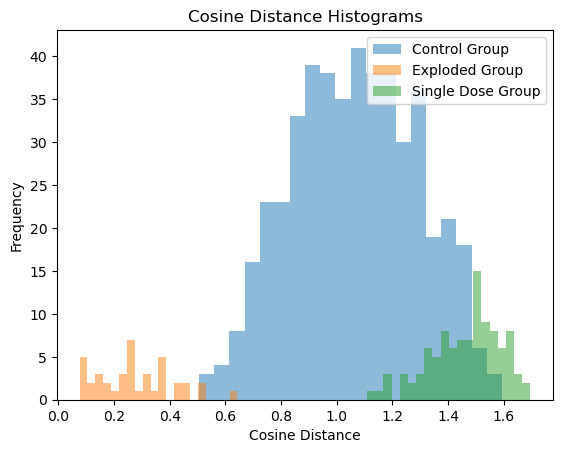

In [14]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
#control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\condall.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"


#cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"
#cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\condall.npy"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex40_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)


In [12]:
123/143

0.8601398601398601

Mean Cosine Distances:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241
Group with middle mean: Control
Middle cluster min: 0.6774
Middle cluster max: 1.4484
Total errors: 20
Accuracy: 0.9527


C:\Users\k54739\AppData\Local\Temp\ipykernel_196276\367429956.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

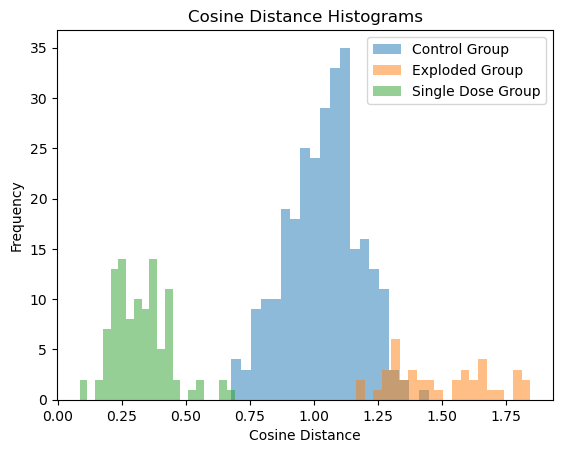

In [7]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
#control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_all.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3504937528.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

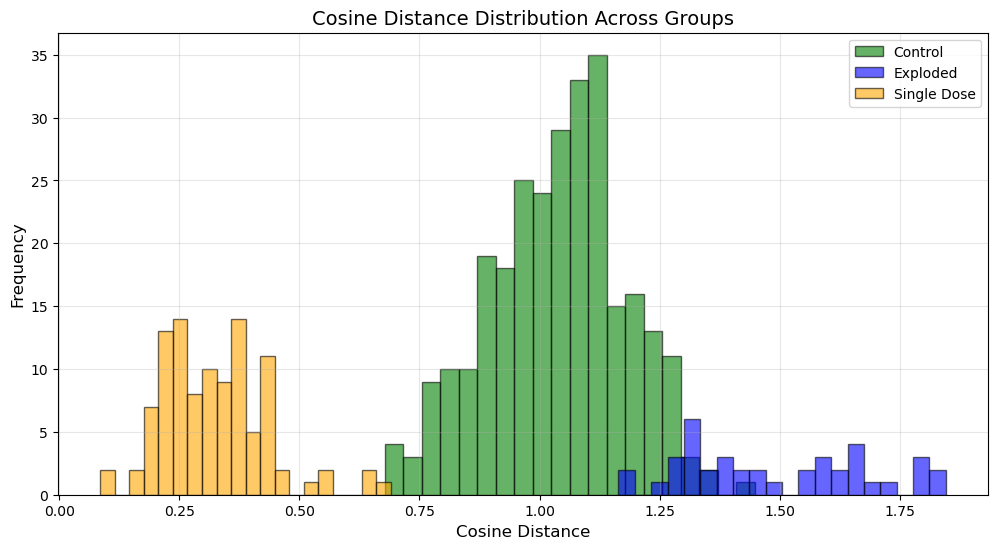


Metrics:
Group-Wise Ranking Accuracy: 0.9739


In [45]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Plot histograms
    plt.figure(figsize=(12, 6))
    plt.hist(control_cosine_distances, bins=bins, alpha=0.6, label="Control", color="green", edgecolor="black")
    plt.hist(exp_cosine_distances, bins=bins, alpha=0.6, label="Exploded", color="blue", edgecolor="black")
    plt.hist(sd_cosine_distances, bins=bins, alpha=0.6, label="Single Dose", color="orange", edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy
    group_wise_accuracy = compute_group_wise_ranking_accuracy(control_cosine_distances, exp_cosine_distances, sd_cosine_distances)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy
    }

def compute_group_wise_ranking_accuracy(control, exp, sd):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        control (np.ndarray): Cosine distances for the control group.
        exp (np.ndarray): Cosine distances for the exploded group.
        sd (np.ndarray): Cosine distances for the single-dose group.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Combine all distances with their respective group labels
    all_distances = np.concatenate([control, exp, sd])
    all_labels = np.concatenate([np.zeros_like(control), np.ones_like(exp), np.full_like(sd, 2)])

    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\3749410762.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

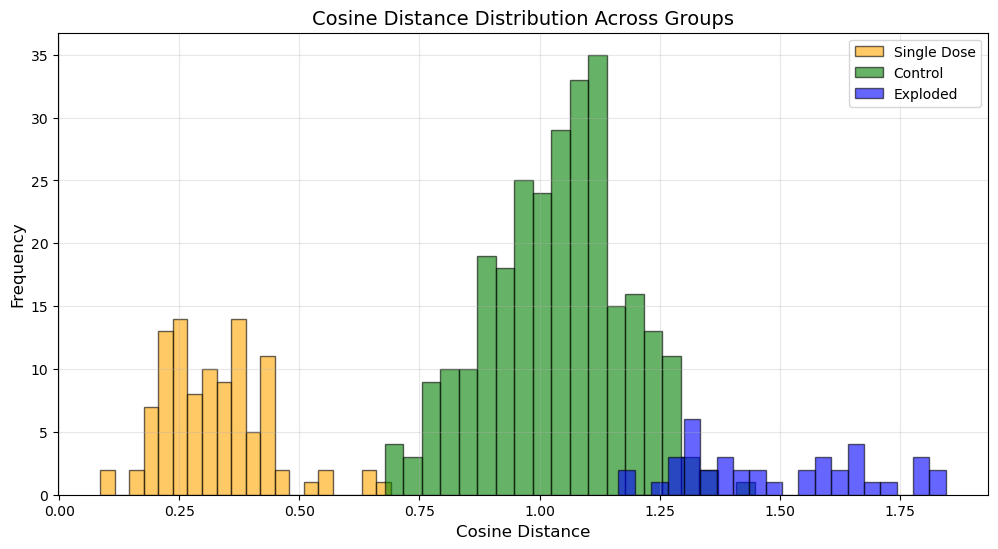


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


In [46]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\393345704.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\Te

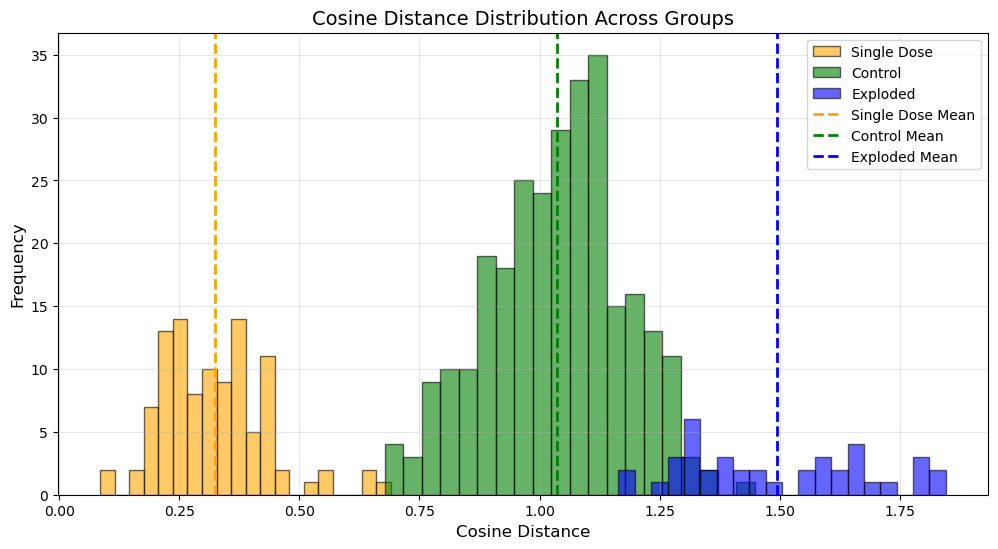


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order and Mean Cosine Distances:


KeyError: 'mean_single_dose'

In [49]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Add vertical lines for mean distances
    # Add vertical lines for mean distances
    for _, _, label, color in group_order:
        if label == "Control":
            mean_distance = mean_control
        elif label == "Exploded":
            mean_distance = mean_exp
        elif label == "Single Dose":
            mean_distance = mean_sd
        else:
            continue  # In case of any other labels

        # Add the vertical line for mean distance
        plt.axvline(mean_distance, color=color, linestyle="dashed", linewidth=2, label=f"{label} Mean")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")
    print("\nDynamic Group Order and Mean Cosine Distances:")
    for _, _, label, _ in group_order:
        mean_distance = locals()[f"mean_{label.lower().replace(' ', '_')}"]
        print(f"{label} Group Mean Cosine Distance: {mean_distance:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241

Dynamic Group Order and Mean Cosine Distances:
Single Dose Group Mean Cosine Distance: 0.3241
Control Group Mean Cosine Distance: 1.0370
Exploded Group Mean Cosine Distance: 1.4934


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

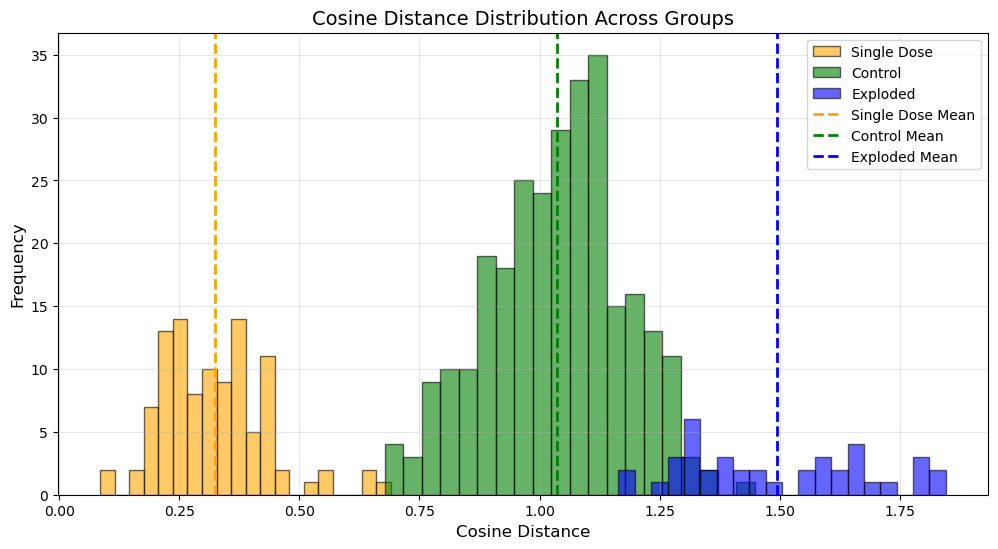


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


Mean Cosine Distance Scores:
Control Group: 1.0370
Exploded Group: 1.4934
Single Dose Group: 0.3241

Dynamic Group Order and Mean Cosine Distances:
Single Dose Group Mean Cosine Distance: 0.3241
Control Group Mean Cosine Distance: 1.0370
Exploded Group Mean Cosine Distance: 1.4934


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

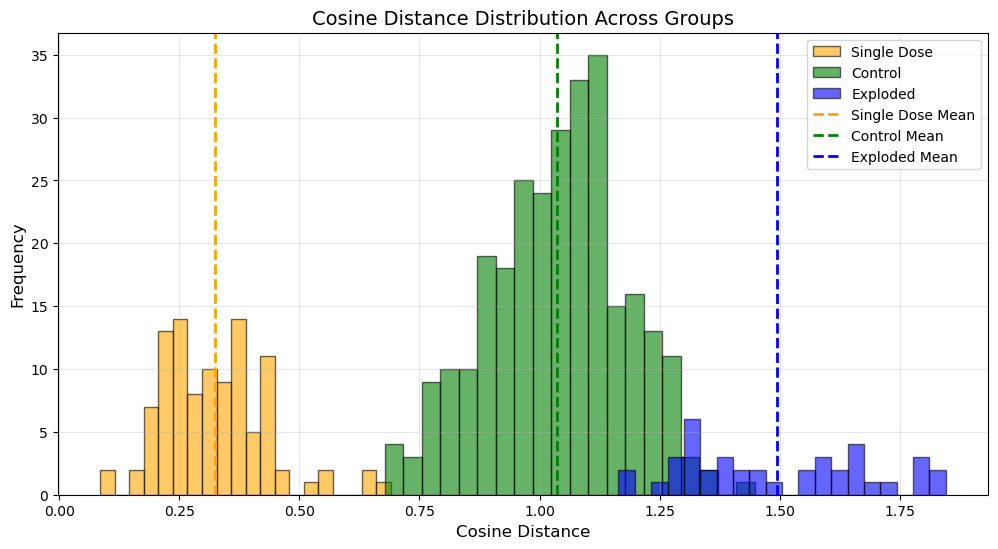


Metrics:
Group-Wise Ranking Accuracy: 0.9763

Dynamic Group Order: ['Single Dose', 'Control', 'Exploded']


In [51]:
import torch
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def calculate_and_plot_cosine_distances(exp_path, control_path, sd_path, centroid_path, bins=20):
    """
    Calculate cosine distances between a centroid and features from multiple groups,
    plot histograms of these distances, and compute Group-Wise Ranking Accuracy metric.

    Parameters:
        exp_path (str): Path to the exploded features .pt file.
        control_path (str): Path to the control features .pt file.
        sd_path (str): Path to the single-dose features .pt file.
        centroid_path (str): Path to the centroid .pt file.
        bins (int): Number of bins for the histogram.

    Returns:
        dict: Contains cosine distances and calculated metrics.
    """
    # Load data
    exp = torch.load(exp_path)
    control = torch.load(control_path)
    sd = torch.load(sd_path)
    cosine_centroid = np.load(centroid_path)

    # Convert tensors to NumPy arrays and normalize
    exp_np_norm = normalize(exp.numpy(), axis=1)
    control_np_norm = normalize(control.numpy(), axis=1)
    sd_np_norm = normalize(sd.numpy(), axis=1)

    # Ensure centroid is reshaped correctly
    cosine_centroid = cosine_centroid.reshape(1, -1)  # Shape: [1, 512]

    # Calculate cosine distances
    control_cosine_distances = 1 - cosine_similarity(control_np_norm, cosine_centroid).flatten()
    exp_cosine_distances = 1 - cosine_similarity(exp_np_norm, cosine_centroid).flatten()
    sd_cosine_distances = 1 - cosine_similarity(sd_np_norm, cosine_centroid).flatten()

    # Calculate mean distances for each group
    mean_control = np.mean(control_cosine_distances)
    mean_exp = np.mean(exp_cosine_distances)
    mean_sd = np.mean(sd_cosine_distances)

    # Print mean scores
    print("Mean Cosine Distance Scores:")
    print(f"Control Group: {mean_control:.4f}")
    print(f"Exploded Group: {mean_exp:.4f}")
    print(f"Single Dose Group: {mean_sd:.4f}")

    # Sort groups dynamically based on mean distances
    group_order = sorted(
        [(mean_control, control_cosine_distances, "Control", "green"),
         (mean_exp, exp_cosine_distances, "Exploded", "blue"),
         (mean_sd, sd_cosine_distances, "Single Dose", "orange")],
        key=lambda x: x[0]  # Sort by mean distance
    )

    # Map labels to the corresponding mean distance
    mean_map = {
        "Control": mean_control,
        "Exploded": mean_exp,
        "Single Dose": mean_sd
    }

    # Print the group order along with the corresponding mean distances
    print("\nDynamic Group Order and Mean Cosine Distances:")
    for _, _, label, _ in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            print(f"{label} Group Mean Cosine Distance: {mean_distance:.4f}")
        else:
            print(f"Mean distance not found for {label}")

    # Plot histograms dynamically in sorted order
    plt.figure(figsize=(12, 6))
    for _, distances, label, color in group_order:
        plt.hist(distances, bins=bins, alpha=0.6, label=label, color=color, edgecolor="black")

    # Add vertical lines for mean distances
    for _, _, label, color in group_order:
        mean_distance = mean_map.get(label, None)
        if mean_distance is not None:
            plt.axvline(mean_distance, color=color, linestyle="dashed", linewidth=2, label=f"{label} Mean")

    # Customize plot
    plt.title("Cosine Distance Distribution Across Groups", fontsize=14)
    plt.xlabel("Cosine Distance", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()

    # Compute Group-Wise Ranking Accuracy dynamically
    all_distances, all_labels = [], []
    for i, (_, distances, label, _) in enumerate(group_order):
        all_distances.append(distances)
        all_labels.append(np.full_like(distances, i))  # Assign dynamic labels based on sorted order

    all_distances = np.concatenate(all_distances)
    all_labels = np.concatenate(all_labels)
    
    group_wise_accuracy = compute_group_wise_ranking_accuracy(all_distances, all_labels)

    # Print metrics
    print("\nMetrics:")
    print(f"Group-Wise Ranking Accuracy: {group_wise_accuracy:.4f}")

    # Return calculated distances and metrics for further use
    return {
        "control_cosine_distances": control_cosine_distances,
        "exp_cosine_distances": exp_cosine_distances,
        "sd_cosine_distances": sd_cosine_distances,
        "group_wise_accuracy": group_wise_accuracy,
        "mean_scores": {
            "Control": mean_control,
            "Exploded": mean_exp,
            "Single Dose": mean_sd
        },
        "group_order": [group[2] for group in group_order]  # Return the sorted group labels
    }

def compute_group_wise_ranking_accuracy(all_distances, all_labels):
    """
    Compute the Group-Wise Ranking Accuracy metric.

    Parameters:
        all_distances (np.ndarray): Combined cosine distances from all groups.
        all_labels (np.ndarray): Corresponding group labels for the distances.

    Returns:
        float: Group-wise ranking accuracy.
    """
    # Sort all distances along with their labels
    sorted_indices = np.argsort(all_distances)
    sorted_labels = all_labels[sorted_indices]

    # Check if group order is preserved
    correct_transitions = 0
    total_transitions = 0
    for i in range(1, len(sorted_labels)):
        if sorted_labels[i - 1] <= sorted_labels[i]:
            correct_transitions += 1
        total_transitions += 1

    accuracy = correct_transitions / total_transitions if total_transitions > 0 else 0
    return accuracy

# File paths
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd103_centroid.npy"

# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]
group_order = distances["group_order"]
print("\nDynamic Group Order:", group_order)


Mean Cosine Distance Scores:
Control Group: 0.5541
Exploded Group: 1.0614
Single Dose Group: 1.0561

Dynamic Group Order and Mean Cosine Distances:
Control Group Mean Cosine Distance: 0.5541
Single Dose Group Mean Cosine Distance: 1.0561
Exploded Group Mean Cosine Distance: 1.0614


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

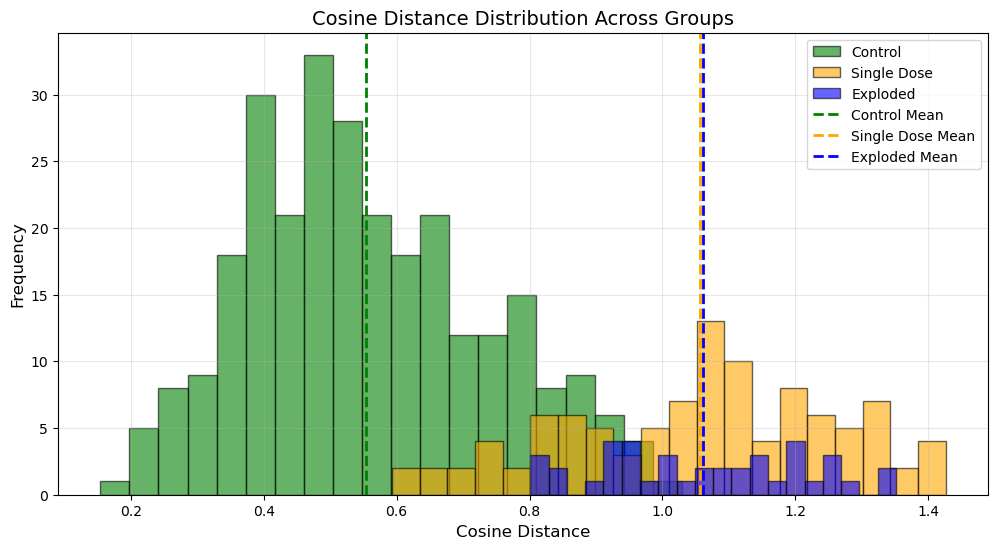


Metrics:
Group-Wise Ranking Accuracy: 0.8697


In [52]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\curated_control_280_centroid.npy"
# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]

Mean Cosine Distance Scores:
Control Group: 1.0378
Exploded Group: 0.2759
Single Dose Group: 1.4606

Dynamic Group Order and Mean Cosine Distances:
Exploded Group Mean Cosine Distance: 0.2759
Control Group Mean Cosine Distance: 1.0378
Single Dose Group Mean Cosine Distance: 1.4606


C:\Users\k54739\AppData\Local\Temp\ipykernel_17164\1468762094.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp = torch.load(exp_path)
C:\Users\k54739\AppData\Local\T

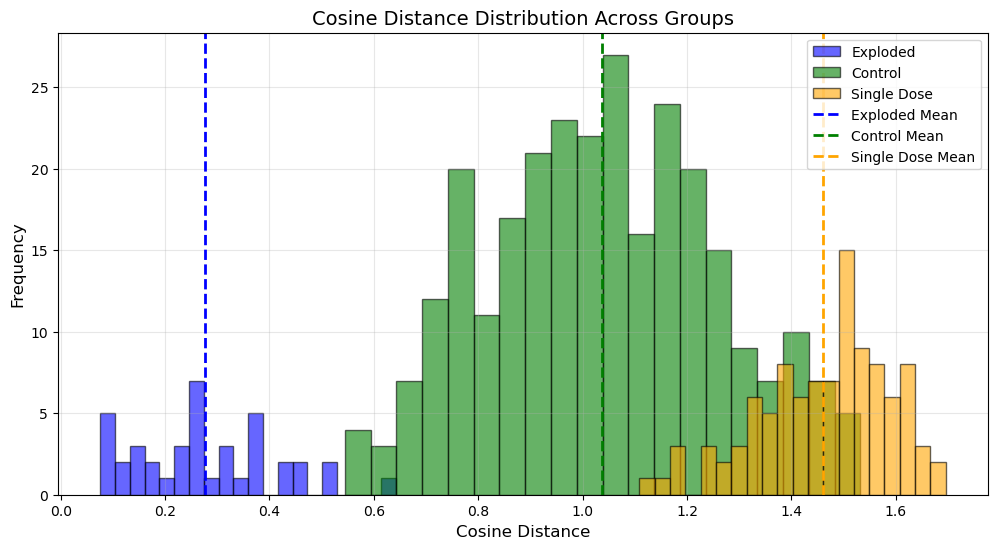


Metrics:
Group-Wise Ranking Accuracy: 0.9218


In [53]:
exp_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex.pt"
control_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\cond7_curated_280.pt"
sd_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\sd.pt"
cosine_centroid_save_path_torch = r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\after_with_cond7_all\ex40_centroid.npy"
# Call the function
distances = calculate_and_plot_cosine_distances(
    exp_save_path_torch,
    control_save_path_torch,
    sd_save_path_torch,
    cosine_centroid_save_path_torch,
    bins=20
)

# Access metrics if needed
group_wise_accuracy = distances["group_wise_accuracy"]

In [4]:
pat  = torch.load(r"C:\Users\k54739\Bibi_new_thesis\thesis\Source_Code\Ranking(prediction)_model\kmeans_ranking\strong_crop\final_ranking\sd.pt")
pat.shape

C:\Users\k54739\AppData\Local\Temp\ipykernel_25372\3307952984.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pat  = torch.load(r"C:\Users\k54739\Bibi_new_thesis\thesis\

torch.Size([103, 20])